In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import plotly.express as px


In [2]:
supply = pd.read_excel(r"C:\Users\parke\Desktop\drivers_acceptance_price.csv")
supply = supply.rename(columns = str.lower)

supply.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pay       1000 non-null   float64
 1   accepted  1000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 15.8 KB


In [ ]:
px.scatter(supply, x = 'pay', y = 'accepted').show('svg')

In [3]:
logit = smf.logit("accepted ~ pay", supply).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.394998
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accepted   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Wed, 30 Nov 2022   Pseudo R-squ.:                  0.4289
Time:                        23:53:11   Log-Likelihood:                -395.00
converged:                       True   LL-Null:                       -691.69
Covariance Type:            nonrobust   LLR p-value:                4.606e-131
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.3158      0.409    -15.455      0.000      -7.117      -5.515
pay            0.2539      0.016     15.979      0.000       0.223       0.285
==============================================================================
"""

In [109]:
# se tthe number of simulations to run
n = 500

# 1 period per month, 12 months
num_periods =12
period = np.arange(0,num_periods)

# Additional parameters
rider_pool = 10000
acquisition_cost = 30
ride_cost = 30

# Coarse grid of acquisitions and rider payments
acquisition_grid = [0,500,1000]
pay_grid = [10,20,30,40]

overall_summaries = []
monthly_summaries = []
pay_vectors = []
acquisition_vectors = []

for i in range(n):


    # Generate a dataframe of all potential riders for each month
    rider = pd.Series(data = np.arange(start = 0, stop =rider_pool), name = 'rider')
    month = pd.Series(data = np.arange(start = 0, stop = num_periods), name = 'month')

    data = pd.merge(rider, month, how = 'cross')
    data = data.assign(acquired = 0,
                        acquisition_month = np.NaN,
                        lam = 0,
                        requests = 0,
                        matches = 0
                    )

    non_acquired = np.arange(0, rider_pool)
    acquired_rider_list = np.array([])

    acquisition_list = np.array([])
    pay_list = np.array([])


    for t in period:

        # draw a number of acquisitions and driver payout for the period
        acquisitions = np.random.choice(acquisition_grid, size = 1)
        acquisition_list = np.concatenate((acquisition_list,acquisitions))

        pay = pd.Series(np.random.choice(pay_grid, size= 1), name = 'pay')
        pay_list = np.concatenate((pay_list,pay))

        # determine the probability that a ride is matched given the payout
        match_prob = logit.predict(pay).iat[0]

        # select the riders to be acquired this period and remove them from the non_acquired list
        acquired = np.random.choice(non_acquired, size = acquisitions, replace = False)
        non_acquired = np.setdiff1d(non_acquired, acquired)
        acquired_rider_list = np.concatenate((acquired_rider_list, acquired))

        # update the relevant columns for the newly acquired
        data.loc[(data['rider'].isin(acquired)) & (data['month'] >= t), 'acquired'] = 1
        data.loc[data['rider'].isin(acquired), 'acquisition_month'] = t
        data.loc[(data['rider'].isin(acquired)) & (data['month'] == t), 'lam'] = 1
        #data.loc[(data['rider'].isin(acquired)) & (data['month'] == t), 'acq_cost'] = acquisition_cost


        # update lambda for the already acquired
        data.loc[(data['month'] == t) & (data['acquired'] == 1) & (data['acquisition_month'] < t) & (data['month'] != 0), 'lam'] = data.groupby(['rider'])['matches'].shift(1)

        # compute ride requests and successful matches for all acquired riders
        filters = (data['rider'].isin(acquired_rider_list)) & (data['month'] == t)
        
        data.loc[filters, 'requests'] = data['lam'].apply(lambda x: np.random.poisson(x, size = 1)[0])
        data.loc[filters, 'matches'] = data['requests'].apply(lambda x: np.round(match_prob*x))

    # save out the pay and acquisition vectors
    pay_series = pd.Series(data = pay_list, name= 'pay')
    acquisition_series = pd.Series(data = acquisition_list, name = 'acquisitions')

    # Add in final useful columns
    df = data.merge(pay_series, how = 'left', left_on='month', right_index= True)
    df['rider_spend'] = df['matches'].multiply(ride_cost)
    df['driver_pay'] = df['matches']*df['pay']
    df['acquisition_cost'] = 0
    df.loc[df['acquisition_month'] == df['month'], 'acquisition_cost'] = 30
    df['profit'] = df['rider_spend'] - df['driver_pay'] - df['acquisition_cost']

    summary = df[['requests','matches','rider_spend','driver_pay','acquisition_cost','profit']].sum()
    monthly_summary = df.groupby('month', as_index = False)[['requests','matches','rider_spend','driver_pay','acquisition_cost','profit']].sum()

    overall_summaries.append(summary)
    monthly_summaries.append(monthly_summary)
    pay_vectors.append(pay_series)
    acquisition_vectors.append(acquisition_series)

pv_df  = pd.DataFrame(data = pay_vectors).reset_index()
ac_df  = pd.DataFrame(data = acquisition_vectors).reset_index()
s_df  = pd.DataFrame(data = overall_summaries).reset_index()


In [154]:
pv_df  = pd.DataFrame(data = pay_vectors).reset_index(drop  =True)
ac_df  = pd.DataFrame(data = acquisition_vectors).reset_index(drop = True)
s_df  = pd.DataFrame(data = overall_summaries).reset_index(drop = True)

pv_df['simulation'] = np.arange(0,n,1)
pv = pd.melt(pv_df, id_vars= 'simulation', var_name = 'month', value_name= 'pay')

ac_df['simulation'] = np.arange(0,n,1)
ac = pd.melt(ac_df, id_vars= 'simulation', var_name = 'month', value_name= 'acquisitions')

In [172]:
top_sims = s_df.sort_values(by = 'profit', ascending = False)['simulation'].head()

print("Simulations with the highest profits:")
s_df.sort_values(by = 'profit', ascending = False).head()



Simulations with the highest profits


,requests,matches,rider_spend,driver_pay,acquisition_cost,profit,simulation
13,7461.0,3271.0,98130.0,95240.0,150000.0,-147110.0,13
29,7075.0,2629.0,78870.0,74780.0,165000.0,-160910.0,29
11,10330.0,4150.0,124500.0,111155.0,180000.0,-166655.0,11
17,8864.0,4423.0,132690.0,143140.0,157500.0,-167950.0,17
83,9186.0,3229.0,96870.0,94235.0,180000.0,-177365.0,83


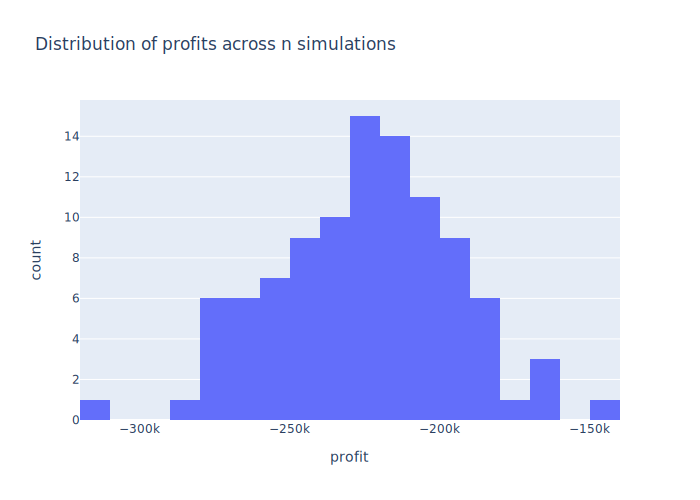

In [173]:
px.histogram(s_df, 
            x = 'profit',
            title = "Distribution of profits across n simulations").show('svg')

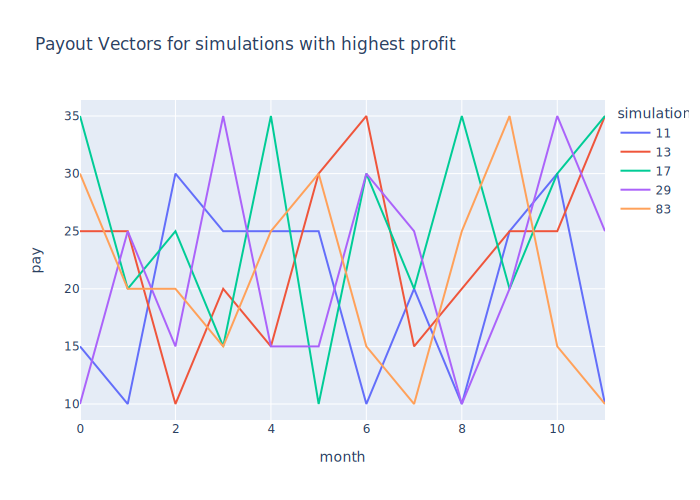

In [170]:
px.line(pv.query("simulation in @top_sims "), 
    x = 'month',
    y = 'pay', 
    color = 'simulation',
    title = "Payout Vectors for simulations with highest profit").show('svg')

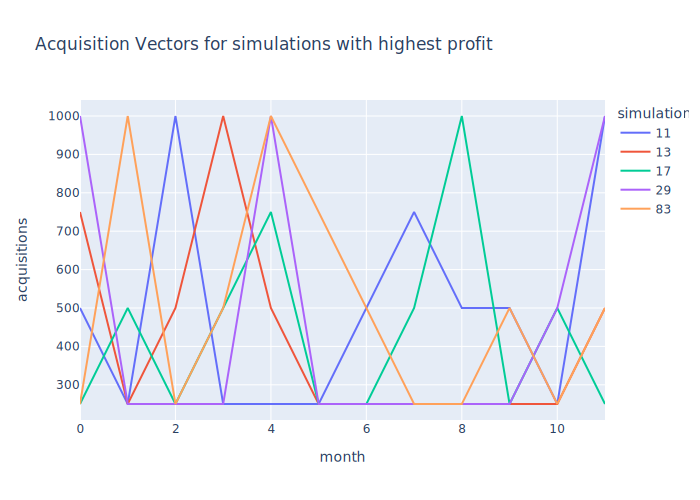

In [171]:
px.line(ac.query("simulation in @top_sims "), 
    x = 'month',
    y = 'acquisitions', 
    color = 'simulation',
    title = "Acquisition Vectors for simulations with highest profit").show('svg')